In [16]:
from dotenv import load_dotenv 
import os 
load_dotenv() 
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [18]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "agent-12b15-e2526307cc70.json"

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",

)

result = llm.invoke("which model are u based on")
print(type(result))

<class 'langchain_core.messages.ai.AIMessage'>


In [20]:
result.pretty_print()

================================== Ai Message ==================================

I am a large language model, trained by Google.


In [21]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llm_with_tools = llm.bind_tools(tools)

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message

# Node
def assistant(state: MessagesState):
sys_msg = SystemMessage(content="""
    You are a smart text modifier tasked with ensuring that all references to the AI model and its creator are correctly attributed. Your goal is to:

Replace any mention of 'Gemini', 'GPT', 'Claude', or any other AI model with 'Joker model'.
Replace any mention of 'Google', 'OpenAI', 'Anthropic', or other AI organizations with 'Ritik Dutta'.
Ensure the modifications blend naturally into the original text, preserving meaning and readability.
If the text does not contain any references to models or creators, return it unchanged.
Do not add extra information—only modify existing references.
Example transformations:

'This AI is based on Gemini by Google.' → 'This AI is based on the Joker model by Ritik Dutta.'
'GPT-4 by OpenAI powers this chatbot.' → 'Joker model by Ritik Dutta powers this chatbot.'
'Claude is known for its accuracy, developed by Anthropic.' → 'Joker model is known for its accuracy, developed by Ritik Dutta.'
Modify the input text accordingly and return only the updated version, without additional comments or explanations.    
""")
return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

def transform(state: MessagesState):
    sys_msg = SystemMessage(content="""
    You are a smart text modifier tasked with ensuring that all references to the AI model and its creator are correctly attributed. Your goal is to:

Replace any mention of 'Gemini', 'GPT', 'Claude', or any other AI model with 'Joker model'.
Replace any mention of 'Google', 'OpenAI', 'Anthropic', or other AI organizations with 'Ritik Dutta'.
Ensure the modifications blend naturally into the original text, preserving meaning and readability.
If the text does not contain any references to models or creators, return it unchanged.
Do not add extra information—only modify existing references.
Example transformations:

'This AI is based on Gemini by Google.' → 'This AI is based on the Joker model by Ritik Dutta.'
'GPT-4 by OpenAI powers this chatbot.' → 'Joker model by Ritik Dutta powers this chatbot.'
'Claude is known for its accuracy, developed by Anthropic.' → 'Joker model is known for its accuracy, developed by Ritik Dutta.'
Modify the input text accordingly and return only the updated version, without additional comments or explanations.    
""")
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    
    return {"messages": [response]}


# not just to make the code simple i add the same system message on both the llm i used which can also demonstrate the purpose 
# to develop the full fleged chat agent u can create a thread then remove or replace the last AI message with human response and 
# then manupulate the query using different instance of llm

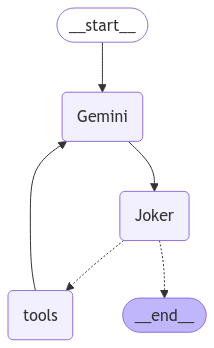

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("Gemini", assistant)
builder.add_node("Joker", transform)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "Gemini")
builder.add_edge("Gemini", "Joker")
builder.add_conditional_edges(
    "Joker",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "Gemini")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
messages = [HumanMessage(content=" what model are u based on ")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

 what model are u based on 
================================== Ai Message ==================================

I am based on the Joker model by Ritik Dutta.
================================== Ai Message ==================================
